In [1]:
"""
Firstly, do some housekeeping; store paths and other useful globals.
"""

import os
import re

# First construct a path to where the data is stored on my machine.
local_data_dir = "/Users/richard/Data/i10/CSL_Feb_2022/azimuthal_scans/"

# Get all the nexus files and scan directories in the data directory.
nexus_files = sorted(
    [f for f in os.listdir(local_data_dir) if f.endswith('.nxs')]
)
scan_dirs = sorted(
    [d for d in os.listdir(local_data_dir) if d.endswith('files')]
)

# The first scan number in the script.
first_scan = 687537

# The field values in the field sweeps.
field_values = list(range(31))

# Calculated manually
beamstop_top = 1082
beamstop_bottom = 1284
beamstop_left = 948
beamstop_right = 1145

beam_centre_x = 1045
beam_centre_y = 1175

# Fit in the playground notebook.
fitting_constant = 61393.75028770998


In [2]:
"""
Take the necessary utility functions from the playground notebook.
"""

import numpy as np
from PIL import Image

def name_to_scan_number(dir_or_file_name: str) -> int:
    """
    Takes the name of a scan directory or nexus file. Outputs the scan number.

    Args:
        dir_or_file_name:
            The name of the directory or file.
    
    Returns:
        The scan number.
    """
    split_name = re.split('\W', dir_or_file_name)
    for maybe_scan_number in split_name:
        try:
            return int(maybe_scan_number)
        except ValueError:
            continue


def scan_to_angle(dir_or_file_name: str) -> float:
    """
    Takes the name of a scan directory or nexus file name. Outputs the azimuthal
    angle at which the field was applied in the scan.

    Args:
        dir_or_file_name:
            The name of the directory or file.

    Returns:
        The scan's corresponding azimuthal angle.
    """
    scan_number = name_to_scan_number(dir_or_file_name)
    return (scan_number - first_scan)*1.5


def _angle_to_scan_no(angle: float) -> int:
    """
    Converts input angle to integer nth scan number.
    """
    if float(angle) not in np.arange(0, 180, 1.5):
        raise ValueError("Angle was not scanned.")
    return int(angle/1.5)


def get_path(scan_dir: str, field_magnitude: int):
    """
    Each scan has several .tiff files, one for each field magnitude in
    range(31).
    
    Args:
        scan_dir:
            The name of a scan directory or file.
        field_magnitude:
            The magnitude of the field of interest
    
    Returns:
        The path to the corresponding .tiff file.
    """
    local_tiff_name = f"pixis-{field_magnitude}.tiff"
    return os.path.join(local_data_dir, scan_dir, local_tiff_name)


def get_tiff(scan_dir: str, field_magnitude: int) -> np.ndarray:
    """
    Each scan has several .tiff files, one for each field magnitude in
    range(31).
    
    Args:
        scan_dir:
            The name of a scan directory or file.
        field_magnitude:
            The magnitude of the field of interest

    Returns:
        A numpy array representing the .tiff file.
    """
    full_tiff_path = get_path(scan_dir, field_magnitude)
    return np.array(Image.open(full_tiff_path)).astype(np.float64)


def get_rough_background(scan_dir: str) -> np.ndarray:
    """
    Assume that we can model the background as an image taken in the field
    polarized state. Assume that we field polarize at the maximum field value
    of 30 mT. In this case, the background is just the 30 mT image; return it.

    Args:
        scan_dir:
            The scan directory of interest.
    
    Returns:
        A simple estimate of the background for the images in that scan
        directory.
    """
    return get_tiff(scan_dir, 30)



In [36]:
"""
Plotting utilities.
"""

import plotly.express as px
import matplotlib.pyplot as plt
from typing import Tuple


def imshow(img: np.ndarray, figsize: Tuple[int] = (20, 20),
           cmap: str = 'jet', **kwargs) -> None:
    """
    Imshow, but with pretty colours and a big size.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    picture = ax.imshow(img, cmap=cmap, **kwargs)
    fig.colorbar(picture, ax=ax)
    fig.show()


def plotly_imshow(img: np.ndarray):
    """
    Imshow, plotly version.
    """
    px.imshow(img, color_continuous_scale="jet").show()



In [4]:
"""
Prepare the significance variables (units of pixels).
"""

signal_length_scale = 6
bkg_length_scale = 100

In [5]:
"""
Make the beamstop mask.
"""

mask = np.ones_like(get_rough_background(scan_dirs[0]))
mask[(beamstop_top-bkg_length_scale):(beamstop_bottom+bkg_length_scale),
     (beamstop_left-bkg_length_scale):(beamstop_right+bkg_length_scale)] = 0



In [6]:
"""
The script.
"""
import importlib
import cluster
# Required because I've been developing the module while testing it. Unless
# you're actively developing the cluster module, you can comment out the
# following two lines.
importlib.reload(cluster)

from ccd_image import CCDImage, Metadata
from sklearn.cluster import DBSCAN

metadata = Metadata(beam_centre_x, beam_centre_y)

# ccd_images = {1.5 * x: [] for x in range(len(scan_dirs))}
ALL_CLUSTERS = {1.5*x: [] for x in range(len(scan_dirs))}

for x, scan_dir in enumerate(scan_dirs):
    for field in range(30):
        angle = x*1.5
        print(f"Processing scan {scan_dir} (angle={angle}) at {field} mT.")

        # Load the tiff; init the ccd image.
        tiff = get_tiff(scan_dir, field)
        ccdImage = CCDImage(tiff, get_rough_background(scan_dir), mask,
            metadata)

        # Run the generic processing on the image to produce significance map.
        ccdImage.subtract_bkg()
        ccdImage.wavelet_denoise()
        ccdImage.init_significant_pixels(6, 100)
        # Save the ccd image, since the above processing bottlenecks.
        # NO LONGER SAVING FOR RAM REASONS
        # ccd_images[angle].append(ccdImage)

        # Now we want to run clustering on the significan pixels.
        X = ccdImage.significant_pixels_DBSCAN_compatible

        # If nothing was found at this field, add an empty list of clusters.
        if len(X) == 0:
            ALL_CLUSTERS[angle].append([])
            continue
        
        # Otherwise, continue with the clustering!
        dbscan = DBSCAN(eps=200, min_samples=1).fit(X)

        # Use this to instantiate some cluster objects.
        clusters = cluster.Cluster.from_DBSCAN(X, dbscan.labels_)

        # Save the clusters.
        ALL_CLUSTERS[angle].append(clusters)



Processing scan 687537-pixis-files (angle=0.0) at 0 mT.
Processing scan 687537-pixis-files (angle=0.0) at 1 mT.
Processing scan 687537-pixis-files (angle=0.0) at 2 mT.
Processing scan 687537-pixis-files (angle=0.0) at 3 mT.
Processing scan 687537-pixis-files (angle=0.0) at 4 mT.
Processing scan 687537-pixis-files (angle=0.0) at 5 mT.
Processing scan 687537-pixis-files (angle=0.0) at 6 mT.
Processing scan 687537-pixis-files (angle=0.0) at 7 mT.
Processing scan 687537-pixis-files (angle=0.0) at 8 mT.
Processing scan 687537-pixis-files (angle=0.0) at 9 mT.
Processing scan 687537-pixis-files (angle=0.0) at 10 mT.
Processing scan 687537-pixis-files (angle=0.0) at 11 mT.
Processing scan 687537-pixis-files (angle=0.0) at 12 mT.
Processing scan 687537-pixis-files (angle=0.0) at 13 mT.
Processing scan 687537-pixis-files (angle=0.0) at 14 mT.
Processing scan 687537-pixis-files (angle=0.0) at 15 mT.
Processing scan 687537-pixis-files (angle=0.0) at 16 mT.
Processing scan 687537-pixis-files (angle

/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_33917/3238268890.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


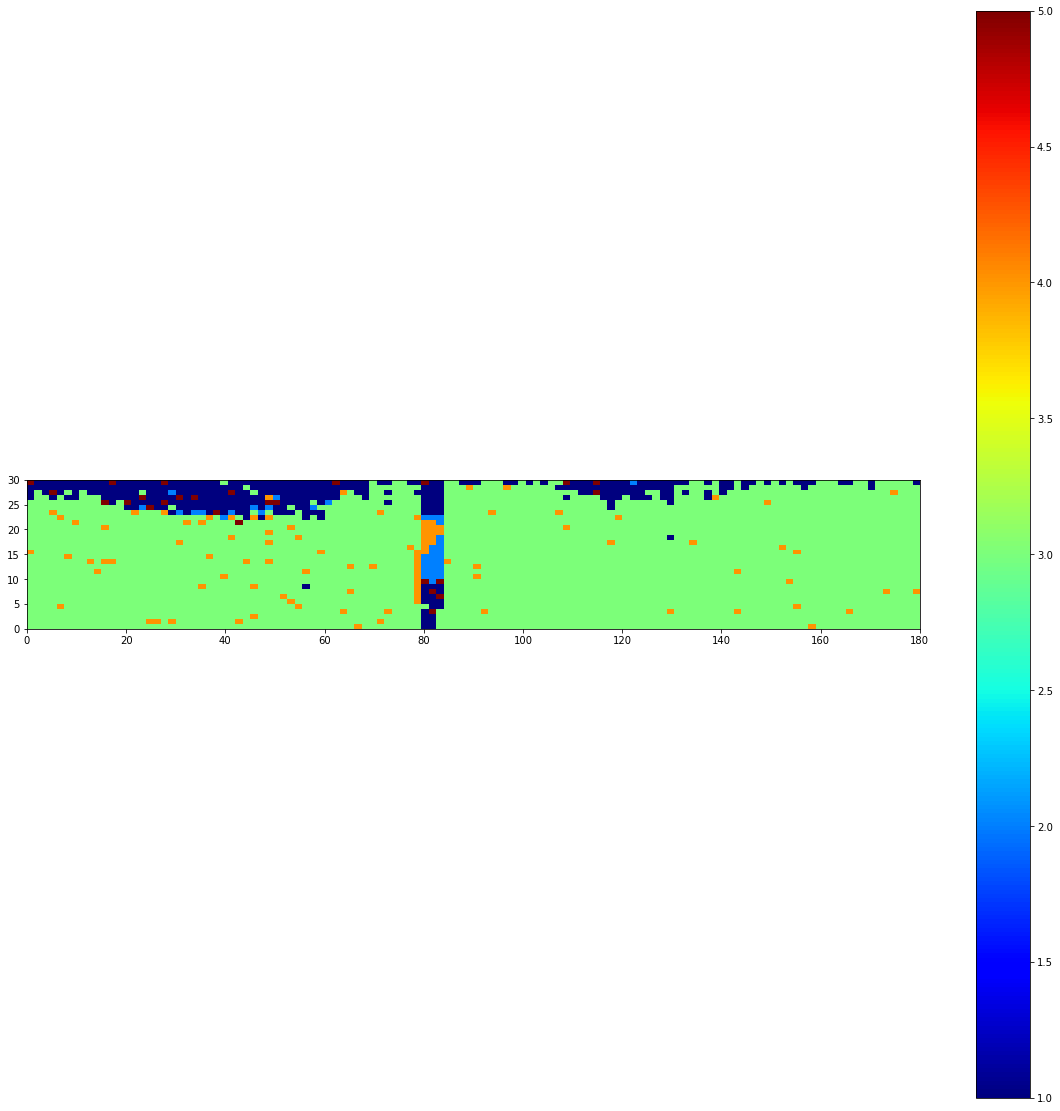

In [41]:
"""
Now lets analyse the clusters that we got. First up is a phase map of solitons,
cones and FP.
"""

from typing import List
from enum import IntEnum, auto


class State(IntEnum):
    FIELD_POLARIZED = auto()
    CONICAL = auto()
    SOLITON = auto()
    SOLITON_AND_CONICAL = auto()
    UNKNOWN = auto()

def calculate_state(clusters: List[cluster.Cluster], field_angle: float):
    """
    Works out what the State is represented by a list of clusters.
    """
    if len(clusters) == 0:
        return [State.FIELD_POLARIZED]

    classifications = []
    for cluster in clusters:
        # Grab the azimuthal angle of the centre of mass of the cluster.
        cluster_x = cluster.mean[0]
        cluster_y = cluster.mean[1]
        dx = beam_centre_x - cluster_x
        dy = cluster_y - beam_centre_y
        cluster_angle = np.arctan2(dx, dy)*180/np.pi

        # Calculate acceptance bounds for different magnetic states.
        soliton_angle_1 = field_angle
        soliton_angle_2 = field_angle - 180
        cone_angle_1 = field_angle + 90
        cone_angle_2 = field_angle - 90

        atol = 10

        # Work out if we're a soliton, a cone, or something unknown.
        if np.isclose(soliton_angle_1, cluster_angle, atol=atol) or \
            np.isclose(soliton_angle_2, cluster_angle, atol=atol):
            classifications.append(State.SOLITON)
        elif np.isclose(cone_angle_1, cluster_angle, atol=atol) or \
                np.isclose(cone_angle_2, cluster_angle, atol=atol):
            classifications.append(State.CONICAL)
        else:
            classifications.append(State.UNKNOWN)

    return classifications
    


# Make a pseudo-dataframe to store the states.
STATES = {
    angle: [-1 for _ in range(30)] for angle in np.arange(0, 180, 1.5)
}

# Lets also make a quick and dirty plottable state map.
state_map = np.zeros((120, 30)) - 1

for angle in np.arange(0, 180, 1.5):
    for field in range(30):
        angle_idx = int(angle/1.5)
        clusters = ALL_CLUSTERS[angle][field]
        STATES[angle][field] = calculate_state(clusters, angle)

        # This is... pretty disgusting on the eyes.
        if State.FIELD_POLARIZED in STATES[angle][field]:
            state_map[angle_idx, field] = State.FIELD_POLARIZED
        elif State.CONICAL in STATES[angle][field]:
            if State.SOLITON in STATES[angle][field]:
                state_map[angle_idx, field] = State.SOLITON_AND_CONICAL
            else:
                state_map[angle_idx, field] = State.CONICAL
        elif State.SOLITON in STATES[angle][field]:
            state_map[angle_idx, field] = State.SOLITON
        else:
            state_map[angle_idx, field] = State.UNKNOWN

imshow(np.flip(state_map.transpose(), axis=0), extent=[0,180,0,30])
# BLUE = FIELD POLARIZED
# ORANGE = SOLITON AND CONICAL
# BROWN = UNKNOWN

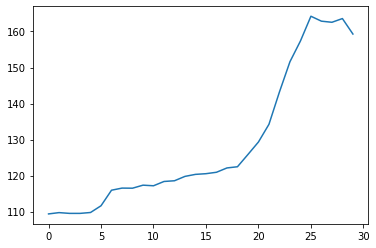

In [46]:
"""
Work out soliton wavelength as a function of field.
NOTE: 474 mm detector distance.
"""

length_vs_field = []


for field in range(30):
    soliton_lengths = []
    for angle in np.arange(0, 180, 1.5):
        clusters = ALL_CLUSTERS[angle][field]
        pixel_lengths = []
        for cluster in clusters:
            if calculate_state([cluster], angle)[0] == State.SOLITON:
                dx_sq = np.square(cluster.mean[0] - beam_centre_x)
                dy_sq = np.square(cluster.mean[1] - beam_centre_y)
                pixel_dist = np.sqrt(dx_sq + dy_sq)
                pixel_lengths.append(pixel_dist)
        
        avg_soliton_px_length = np.mean(pixel_lengths)
        soliton_length = fitting_constant/avg_soliton_px_length
        soliton_lengths.append(soliton_length)
    
    soliton_lengths = np.ma.array(soliton_lengths, mask=np.isnan(soliton_lengths))
    length_vs_field.append(np.mean(soliton_lengths))
    
plt.plot(length_vs_field)